# Using rail_fsps to generate galaxy rest-frame spectral energy distributions and  compute apparent magnitudes

author: Luca Tortorelli, Eric Charles
    
last run successfully: May 29th, 2023
    
This notebook demonstrates how to use rail_fsps to generate galaxy rest-frame spectral energy distributions (SEDs) with FSPS and how to compute apparent magnitudes from them. We will also show how to use Ceci to do the same.

In [1]:
import os
os.environ['SPS_HOME']="/home/josue/photoz/fsps"
import rail
from rail.creation.engines.fsps_sed_modeler import *
from rail.creation.engines.fsps_photometry_creator import *
from rail.core.stage import RailStage
import numpy as np
import matplotlib.pyplot as plt
import h5py

We'll start by setting up the Rail data store. RAIL uses ceci, which is designed for pipelines rather than interactive notebooks, the data store will work around that and enable us to use data interactively. See the rail/examples/goldenspike/goldenspike.ipynb example notebook for more details on the Data Store.

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

We generate some mock input data for the sed modeler class that we store in an hdf5 file.

In [3]:
from rail.core.utils import RAILDIR
default_rail_fsps_files_folder = os.path.join(rail.__path__[1], 'examples_data', 'creation_data', 'data',
                                              'fsps_default_data')

n_galaxies = 2

redshift = np.arange(0.1, 1.1, 0.1)

gal_t_table = np.linspace(0.05, 13.8, 100) # age of the universe in Gyr
gal_sfr_table = np.random.uniform(0, 10, gal_t_table.size) # SFR in Msun/yr
tabulated_sfh = np.full((n_galaxies, 2, len(gal_sfr_table)), [gal_t_table,gal_sfr_table])

gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

stellar_metallicity = np.full(n_galaxies, gal_lgmet)
stellar_age = np.full(n_galaxies, 2.)
stellar_velocity_dispersion = np.full(n_galaxies, 100.)
gas_ionization = np.full(n_galaxies, -1)
gas_metallicity = np.full(n_galaxies, 0.0)
dust1_birth_cloud = np.full(n_galaxies, 0.1)
dust2_diffuse = np.full(n_galaxies, 0.1)
dust_calzetti_modifier = np.full(n_galaxies, -1.)
dust_gamma = np.full(n_galaxies, 0.01)
dust_umin = np.full(n_galaxies, 1.0)
dust_qpah = np.full(n_galaxies, 3.5)
f_agn = np.full(n_galaxies, 0.01)
tau_agn = np.full(n_galaxies, 10.0)

wave_lsf = np.linspace(3000, 10000, 2000)
sigma_lsf = np.full_like(wave_lsf, 0)
tabulated_lsf = np.full((n_galaxies, 2, len(wave_lsf)), [wave_lsf, sigma_lsf])

filename = os.path.join(default_rail_fsps_files_folder, 'input_galaxy_properties_fsps.hdf5')
h5table = h5py.File(filename, 'w')
meta = h5table.create_group('meta')
meta.create_dataset(name='redshift', data=redshift)
data = h5table.create_group('model')
data.create_dataset(name='stellar_metallicity', data=stellar_metallicity)
data.create_dataset(name='stellar_age', data=stellar_age)
data.create_dataset(name='stellar_velocity_dispersion', data=stellar_velocity_dispersion)
data.create_dataset(name='gas_ionization', data=gas_ionization)
data.create_dataset(name='gas_metallicity', data=gas_metallicity)
data.create_dataset(name='dust1_birth_cloud', data=dust1_birth_cloud)
data.create_dataset(name='dust2_diffuse', data=dust2_diffuse)
data.create_dataset(name='dust_calzetti_modifier', data=dust_calzetti_modifier)
data.create_dataset(name='dust_gamma', data=dust_gamma)
data.create_dataset(name='dust_umin', data=dust_umin)
data.create_dataset(name='dust_qpah', data=dust_qpah)
data.create_dataset(name='f_agn', data=f_agn)
data.create_dataset(name='tau_agn', data=tau_agn)
data.create_dataset(name='tabulated_lsf', data=tabulated_lsf)
data.create_dataset(name='tabulated_sfh', data=tabulated_sfh)
h5table.close()

Let's create an FSPSSedModeler class object. The latter has a number of configuration parameters to set. All the parameters have default values. Therefore, if the user is not sure about a particular value for a certain parameter, the latter can be left at default. A short description of each parameter can be found in src/rail/creation/engines/fsps_sed_modeler.py. 

We run the FSPSSedModeler in sequential mode. Note that each galaxy spectrum takes a few seconds to generate, so it is advisable to proceed in this way only for a limited sample of objects or for testing the code.

In [4]:
sedmodel = FSPSSedModeler.make_stage(name='FSPS_sed_model', zcontinuous=1, add_agb_dust_model=True,
                                           add_dust_emission=True, add_igm_absorption=False, add_neb_emission=True,
                                           add_neb_continuum=True, add_stellar_remnants=True, nebemlineinspec=True,
                                           smooth_velocity=True, smooth_lsf=True, imf_type=1, min_wavelength=3000,
                                           max_wavelength=10000, sfh_type=3, dust_type=4, tabulated_sfh_key='tabulated_sfh',
                                           tabulated_lsf_key='tabulated_lsf',
                                           redshifts_key='redshift', stellar_metallicities_key='stellar_metallicity',
                                           stellar_ages_key='stellar_age', velocity_dispersions_key='stellar_velocity_dispersion',
                                           gas_ionizations_key='gas_ionization', gas_metallicities_key='gas_metallicity',
                                           dust_birth_cloud_key='dust1_birth_cloud', dust_diffuse_key='dust2_diffuse',
                                           dust_powerlaw_modifier_key='dust_calzetti_modifier', 
                                           dust_emission_gamma_key='dust_gamma', dust_emission_umin_key='dust_umin',
                                           dust_emission_qpah_key='dust_qpah', fraction_agn_bol_lum_key='f_agn',
                                           agn_torus_opt_depth_key='tau_agn', physical_units=True,
                                           restframe_wave_key='restframe_wavelengths', restframe_sed_key='restframe_seds',
                                           hdf5_groupname='model')

We add the generated data to the hdf5handle

In [5]:
trainFile = os.path.join(filename)
h5table = h5py.File(trainFile, 'r')
sedmodel.add_data('input', h5table)

Inserting handle into data store.  input: None, FSPS_sed_model
seguimos


Here we show the example where we provide tabulated star-formation histories to generate the final SED. In this case, FSPS outputs the emission per total stellar mass. We call the fit_model() function to generate the model SEDs.
The fit_model function parameters have the same meaning of the Python-FSPS ones.

In [6]:
sedmodel.fit_model(compute_vega_mags=False, vactoair_flag=False, compute_light_ages=False, cloudy_dust=False,
                   agb_dust=1.0, tpagb_norm_type=2, dell=0.0, delt=0.0, redgb=1.0, agb=1.0, fcstar=1.0, fbhb=0.0,
                   sbss=0.0, pagb=1.0, pmetals=2.0, imf_upper_limit=120, imf_lower_limit=0.08, imf1=1.3, imf2=2.3,
                   imf3=2.3, vdmc=0.08, mdave=0.5, evtype=-1, masscut=150.0, igm_factor=1.0, tau=1.0, const=0.0,
                   sf_start=0.0, sf_trunc=0.0, fburst=0.0, tburst=11.0, sf_slope=0.0,  dust_tesc=7.0, dust1=0.0,
                   dust2=0.0, dust_clumps=-99., frac_nodust=0.0, frac_obrun=0.0, dust_index=-0.7, dust1_index=-1.0,
                   mwr=3.1, uvb=1.0, wgp1=1, wgp2=1, wgp3=1, duste_gamma=0.01, duste_umin=1.0, duste_qpah=3.5,
                   redshifts= redshift)

Process 0 running creator on chunk 0 - 2
Inserting handle into data store.  model_FSPS_sed_model: inprogress_model_FSPS_sed_model.hdf5, FSPS_sed_model


In [7]:
rest_frame_sed_models = sedmodel.get_data('model')

We plot the first spectrum to check that the SED generation worked correctly.

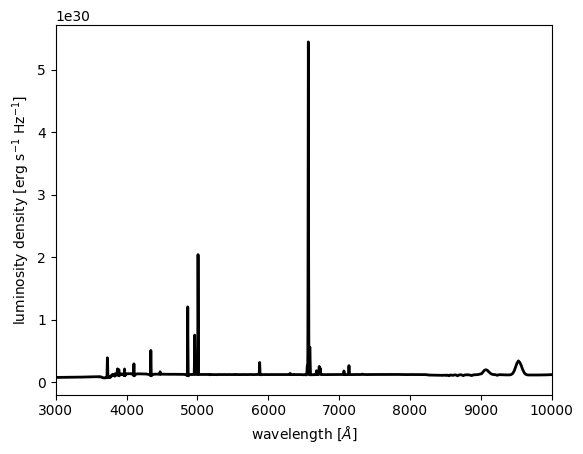

In [8]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(rest_frame_sed_models['wavelenghts'][0], rest_frame_sed_models['restframe_seds'][0],
         lw=2, color='black')
plt.xlim(3000, 10000)
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'luminosity density [$\mathrm{erg \ s^{-1} \ Hz^{-1}}$]')
plt.show()

Running it with ceci

In [ ]:
trainFile = os.path.join(default_rail_fsps_files_folder, 'input_galaxy_properties_fsps.hdf5')

In [ ]:
import rail
from rail.core.stage import RailStage
from rail.creation.engines.fsps_sed_modeler import *
import os
# RAILDIR = '/Users/Luca.Tortorelli/RAIL/src/'

DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [ ]:
FSPS_sed_model = FSPSSedModeler.make_stage(name='FSPS_sed_model', zcontinuous=1, add_agb_dust_model=True,
                                           add_dust_emission=True, add_igm_absorption=False, add_neb_emission=True,
                                           add_neb_continuum=True, add_stellar_remnants=True, nebemlineinspec=True,
                                           smooth_velocity=True, smooth_lsf=True, imf_type=1, min_wavelength=3000,
                                           max_wavelength=10000, sfh_type=3, dust_type=4, tabulated_sfh_key='tabulated_sfh',
                                           tabulated_lsf_key='tabulated_lsf',
                                           redshifts_key='redshift', stellar_metallicities_key='stellar_metallicity',
                                           stellar_ages_key='stellar_age', velocity_dispersions_key='stellar_velocity_dispersion',
                                           gas_ionizations_key='gas_ionization', gas_metallicities_key='gas_metallicity',
                                           dust_birth_cloud_key='dust1_birth_cloud', dust_diffuse_key='dust2_diffuse',
                                           dust_powerlaw_modifier_key='dust_calzetti_modifier', 
                                           dust_emission_gamma_key='dust_gamma', dust_emission_umin_key='dust_umin',
                                           dust_emission_qpah_key='dust_qpah', fraction_agn_bol_lum_key='f_agn',
                                           agn_torus_opt_depth_key='tau_agn', physical_units=True,
                                           restframe_wave_key='restframe_wavelengths', restframe_sed_key='restframe_seds',
                                           hdf5_groupname='model')

In [ ]:
import ceci
pipe = ceci.Pipeline.interactive()
stages = [FSPS_sed_model]
for stage in stages:
    pipe.add_stage(stage)

In [ ]:
help(pipe.initialize)

In [ ]:
pipe.initialize(dict(input=trainFile), dict(output_dir='./temp_output_rail_fsps', log_dir='./logs_rail_fsps',
                                            resume=False, nprocess=2), None)
pipe.save('./temp_output_rail_fsps/pipe_saved.yml')


In [ ]:
import ceci
pr = ceci.Pipeline.read('./temp_output_rail_fsps/pipe_saved.yml')
pr.run()

In [ ]:
import tables_io
rest_frame_sed_models = tables_io.read('inprogress_model_FSPS_sed_model.hdf5')

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(rest_frame_sed_models['wavelenghts'][0], rest_frame_sed_models['restframe_seds'][0],
         lw=2, color='black')
plt.xlim(3000, 10000)
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'luminosity density [$\mathrm{erg \ s^{-1} \ Hz^{-1}}$]')
plt.show()

# IN PROGRESS...

Now we use these rest-frame SEDs to generate LSST photometry at user-provided redshifts.
For this we need the FSPSPhotometryCreator class. The class parameters are:

- filter_data: path to the npy file containing filter transmission curves. The npy file must be a structured array with key names '{}_filter_wave'.format(waveband) and '{}_filter_trans'.format(waveband). Wavelengths must be in Angstrom.
- rest_frame_sed_models: ModelHandle or pickle file containing the rest-frame SEDs generated by the FSPSSedModeler class.
- galaxy_redshifts: same meaning as above.
- Om0, Ode0, w0, wa, h: cosmological parameters for a w0waCDM cosmology
- use_planck_cosmology: True to overwrite the cosmological parameters with Planck15 cosmology model from Astropy
- physical_units: same meaning as above.

In [ ]:
from rail.core.utils import RAILDIR
default_rail_files_folder = os.path.join(RAILDIR, 'rail', 'examples', 'testdata')

phot_creator = FSPSPhotometryCreator.make_stage(name='FSPS_photometry', 
                                                filter_data=os.path.join(default_rail_files_folder, 'lsst_filters.npy'),
                                                rest_frame_sed_models='model_FSPS_sed_model.pkl',
                                                galaxy_redshifts=os.path.join(DRN, 'rail_fsps_test_redshifts.npy'),
                                                Om0=0.3, Ode0=0.7, w0=-1, wa=0., h=0.7,
                                                use_planck_cosmology=True, physical_units=True)

We call the sample method to generate LSST photometry once the class has been initialised. The output is a table in Fits format, with three columns: sequential ID, redshifts, apparent AB magnitudes

In [ ]:
output_table = phot_creator.sample()

In [ ]:
print(output_table.data)

The RAIL stages can be chained together conveniently using Ceci. The following is an example of how the FSPSSedGenerator and FSPSPhotometryCreator can be run as part of the pipeline Ceci stages. 

In [ ]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [ ]:
sedmodel_forceci = FSPSSedModeler.make_stage(name='FSPS_sed_model', zcontinuous=1, add_neb_emission=True,
                                             add_neb_continuum=True, nebemlineinspec=True,
                                             smooth_velocity=True, smooth_lsf=False, imf_type=1,
                                             min_wavelength=1000, max_wavelength=10000, sfh_type=3,
                                             dust_type=4, galaxy_metallicities=os.path.join(DRN, 'rail_fsps_test_metallicities.npy'),
                                             galaxy_ages=os.path.join(DRN, 'rail_fsps_test_ages.npy'),
                                             galaxy_vel_disp=os.path.join(DRN, 'rail_fsps_test_veldisp.npy'),
                                             gas_ionization_params=os.path.join(DRN, 'rail_fsps_test_gasioniz.npy'),
                                             gas_metallicity_params=os.path.join(DRN, 'rail_fsps_test_gasmetal.npy'),
                                             dust_birth_cloud_params=os.path.join(DRN, 'rail_fsps_test_dust1.npy'), 
                                             dust_diffuse_params=os.path.join(DRN, 'rail_fsps_test_dust2.npy'),
                                             dust_powerlaw_modifier_params=os.path.join(DRN, 'rail_fsps_test_dustindex.npy'),
                                             dust_emission_gamma_params=os.path.join(DRN, 'rail_fsps_test_dustgamma.npy'),
                                             dust_emission_umin_params=os.path.join(DRN, 'rail_fsps_test_dustumin.npy'),
                                             dust_emission_qpah_params=os.path.join(DRN, 'rail_fsps_test_dustqpah.npy'),
                                             fraction_agn_bol_lum_params=os.path.join(DRN, 'rail_fsps_test_agnbol.npy'),
                                             agn_torus_opt_depth_params=os.path.join(DRN, 'rail_fsps_test_agntorus.npy'),
                                             physical_units=True)

In [ ]:
phot_creator_forceci = FSPSPhotometryCreator.make_stage(name='FSPS_photometry', 
                                                        filter_data=os.path.join(default_rail_files_folder, 'lsst_filters.npy'),
                                                        rest_frame_sed_models='model_FSPS_sed_model.pkl',
                                                        galaxy_redshifts=os.path.join(DRN, 'rail_fsps_test_redshifts.npy'),
                                                        Om0=0.3, Ode0=0.7, w0=-1, wa=0., h=0.7,
                                                        use_planck_cosmology=True, physical_units=True)

In [ ]:
pipe = ceci.Pipeline.interactive()
stages = [sedmodel_forceci, phot_creator_forceci]
for stage in stages:
    pipe.add_stage(stage)

In [ ]:
pipe.initialize(dict(input='model_FSPS_sed_model.pkl'), dict(output_dir='./temp_output', log_dir='./logs', resume=False, nprocess=2), 
                './temp_output/pipe_sed_fsps_config.yml')

#pipe.initialize(dict(stages_config='./temp_output/pipe_sed_fsps_config.yml'), dict(input=''), dict(output_dir='./temp_output', log_dir='./logs', resume=False, nprocess=2))
pipe.save('./temp_output/pipe_saved.yml')
pr = ceci.Pipeline.read('./temp_output/pipe_saved.yml')
pr.run()


The creation of galaxy SEDs is a computationally intensive process. To speed things up, it is convenient to parallelize the process using MPI. To do that, one needs to set the parameters into the configuration file pipe_saved_config.yml. An example command to be run in the command line with n_cores is:

mpiexec -n n_cores --mpi python3 -m rail SedGenerator --input=test_fsps_sed.fits --name=sed_generator_test --config=pipe_saved_config.yml --output=output_sed_generator_test.fits
